In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost

In [116]:
df = pd.read_csv('data/train.csv')

In [117]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [118]:
df.passenger_count = df.passenger_count.astype(np.uint8)
df.vendor_id = df.vendor_id.astype(np.uint8)
df.trip_duration = df.trip_duration.astype(np.uint32)
for c in [c for c in df.columns if c.endswith('tude')]:
    df.loc[:,c] = df[c].astype(np.float32)
print(df.memory_usage().sum()/2**20)
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime=pd.to_datetime(df.dropoff_datetime)
df['pu_hour'] = df.pickup_datetime.dt.hour
df['yday'] = df.pickup_datetime.dt.dayofyear
df['wday'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month

75.11792755126953


In [119]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,164,6,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,19,1,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,97,2,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,86,5,3


In [120]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
corr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pu_hour,yday,wday,month
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.009299,-0.006025,0.001311,-0.006221
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,0.009101,-0.001784,0.025191,-0.002143
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.010150,0.004263,-0.016356,0.004474
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,0.010603,-0.002516,-0.028976,-0.001439
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,-0.022455,0.004612,-0.001130,0.004758
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,0.013612,-0.001554,-0.021762,-0.000607
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.003690,0.006625,-0.000708,0.006607
pu_hour,0.009299,0.009101,0.010150,0.010603,-0.022455,0.013612,0.003690,1.000000,-0.003340,-0.084255,-0.003438
yday,-0.006025,-0.001784,0.004263,-0.002516,0.004612,-0.001554,0.006625,-0.003340,1.000000,-0.013615,0.985657
wday,0.001311,0.025191,-0.016356,-0.028976,-0.001130,-0.021762,-0.000708,-0.084255,-0.013615,1.000000,-0.014544


자기 자신을 제외하고 다른 요소들과 얼마나 관련이 되어있는지를 파악하는 heatmap

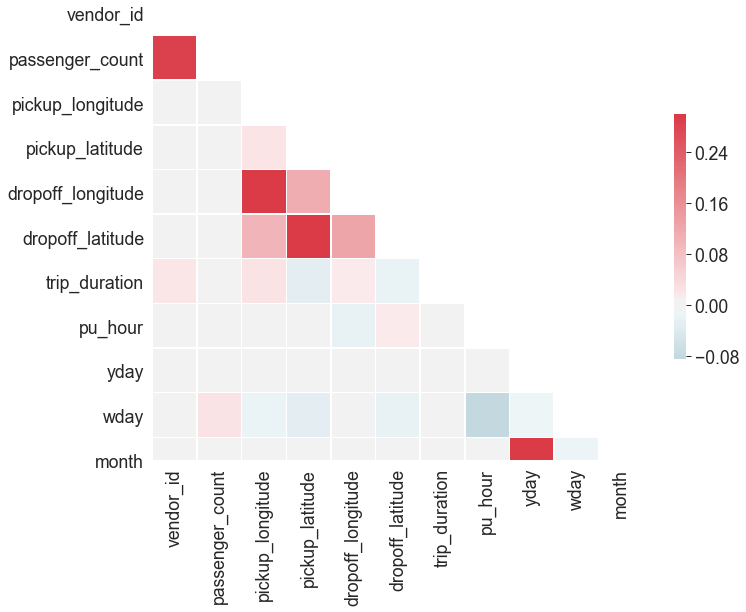

In [121]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

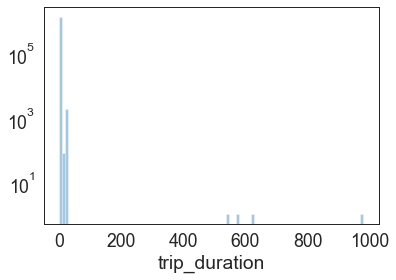

In [122]:
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=100,kde=False,hist_kws={'log':True})

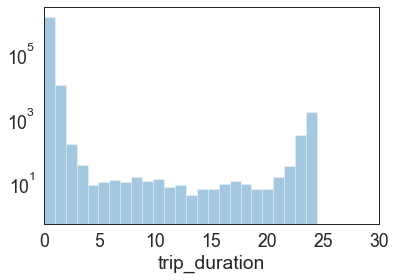

In [123]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlim(0,30)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=1000,kde=False,hist_kws={'log':True})

In [124]:
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = km *  0.621371
    return miles

In [125]:
df['distance'] = haversine(df.pickup_longitude, df.pickup_latitude,
                                           df.dropoff_longitude, df.dropoff_latitude)

In [126]:
wdf = pd.read_csv('data/weather_data_nyc_centralpark_2016.csv')

In [127]:
wdf.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [128]:
wdf['date']=pd.to_datetime(wdf.date,format='%d-%m-%Y')
wdf['yday'] = wdf.date.dt.dayofyear

In [129]:
wdf.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,yday
0,2016-01-01,42,34,38.0,0.00,0.0,0,1
1,2016-01-02,40,32,36.0,0.00,0.0,0,2
2,2016-01-03,45,35,40.0,0.00,0.0,0,3
3,2016-01-04,36,14,25.0,0.00,0.0,0,4
4,2016-01-05,29,11,20.0,0.00,0.0,0,5


In [130]:
wdf['snowfall'] = wdf['snow fall'].replace(['T'],0.05).astype(np.float32)
wdf['precipitation'] = wdf['precipitation'].replace(['T'],0.05).astype(np.float32)
wdf['snowdepth'] = wdf['snow depth'].replace(['T'],0.05).astype(np.float32)

In [131]:
df = pd.merge(df,wdf,on='yday')

In [132]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224525,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0


In [133]:
df = df.drop(['date','maximum temperature','minimum temperature'],axis=1)

In [134]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224525,45.5,0.29,0.0,0,0.0,0.0
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0


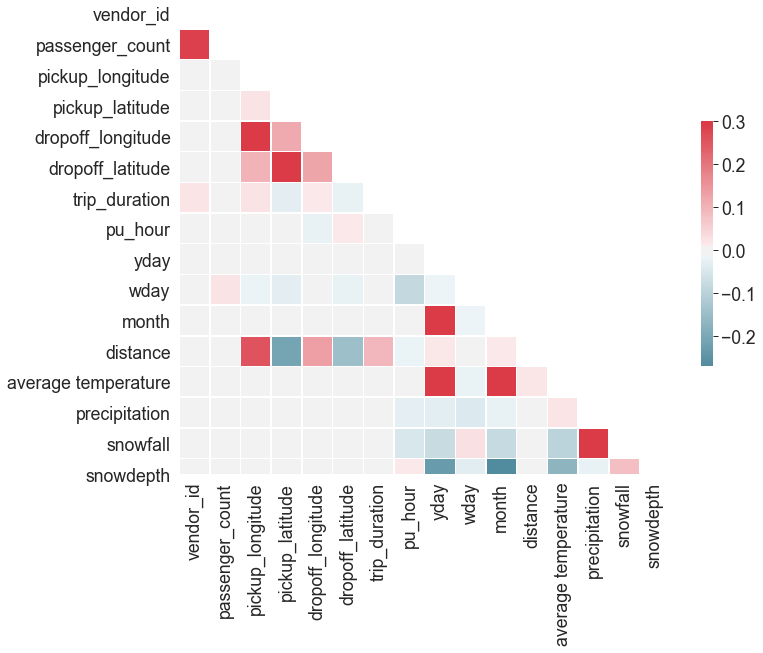

In [135]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

In [136]:
corr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snowfall,snowdepth
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.009299,-0.006025,0.001311,-0.006221,0.008109,-0.005760,0.001385,0.000207,0.006036
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,0.009101,-0.001784,0.025191,-0.002143,0.010306,-0.001203,0.001415,0.000510,0.000733
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.010150,0.004263,-0.016356,0.004474,0.259780,0.005547,0.001418,-0.003288,0.003602
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,0.010603,-0.002516,-0.028976,-0.001439,-0.210354,-0.002011,-0.004180,-0.005058,-0.000112
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,-0.022455,0.004612,-0.001130,0.004758,0.134033,0.005502,0.001660,0.000774,0.001092
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,0.013612,-0.001554,-0.021762,-0.000607,-0.142128,-0.000997,-0.002710,-0.002434,0.000454
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.003690,0.006625,-0.000708,0.006607,0.094777,0.004574,-0.002590,-0.000190,0.002716
pu_hour,0.009299,0.009101,0.010150,0.010603,-0.022455,0.013612,0.003690,1.000000,-0.003340,-0.084255,-0.003438,-0.015813,-0.004948,-0.028656,-0.048589,0.014215
yday,-0.006025,-0.001784,0.004263,-0.002516,0.004612,-0.001554,0.006625,-0.003340,1.000000,-0.013615,0.985657,0.016443,0.837212,-0.031407,-0.077248,-0.229351
wday,0.001311,0.025191,-0.016356,-0.028976,-0.001130,-0.021762,-0.000708,-0.084255,-0.013615,1.000000,-0.014544,0.007599,-0.019799,-0.041673,0.028427,-0.034647


In [137]:
fastest1 = pd.read_csv('data/fastest_routes_train_part_1.csv')
fastest2 = pd.read_csv('data/fastest_routes_train_part_2.csv')
fastest = pd.concat([fastest1,fastest2],ignore_index=True)
fastest = fastest.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
fastest.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [138]:
df = pd.merge(df,fastest,on='id',how='outer')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224525,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3


In [139]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

조금 돌아가더라도(total_distance > distance) 시간이 더 적게 걸리는 루트(trip_duration > total_travel_time)

In [140]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224525,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3


In [141]:
mask = ((df.trip_duration > 60) & (df.distance < 0.05))
df = df[~mask]
mask = (df.trip_duration < 60) 
df = df[~mask]
mask =  df.trip_duration > 79200
df = df[~mask]
mask = df.distance/(df.trip_duration/3600) > 60
df = df[~mask]
df.trip_duration = df.trip_duration.astype(np.uint16)
df = df[df.passenger_count > 0]

In [142]:
m = df.groupby(['wday','vendor_id'])[['trip_duration']].apply(np.median)
m.name = 'trip_duration_median'
df = df.join(m, on=['wday','vendor_id'])

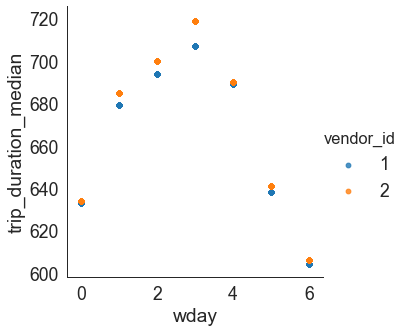

In [143]:
sns.lmplot(y='trip_duration_median', x='wday',data=df, fit_reg=False, hue='vendor_id')

In [144]:
m = df.groupby(['pu_hour','vendor_id'])[['trip_duration']].apply(np.median)
m.name ='trip_duration_median_hour'
df = df.join(m, on=['pu_hour','vendor_id'])

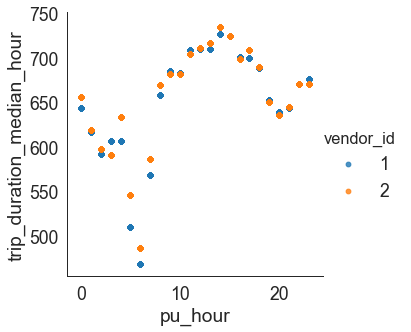

In [145]:
sns.lmplot(y='trip_duration_median_hour', x='pu_hour',data=df, fit_reg=False, hue='vendor_id')

In [146]:
jfk_lon = -73.778889
jfk_lat = 40.639722
lga_lon = -73.872611
lga_lat = 40.77725

jfk airport부터 pickup dropoff까지의 거리 
lga airport부터 pickup dropoff까지의 거리

In [147]:
df['jfk_pickup_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['lga_pickup_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['jfk_dropoff_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
df['lga_dropoff_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)

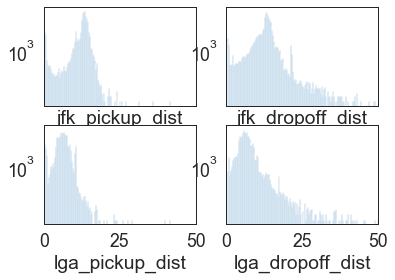

In [148]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True)
ax[0,0].set_xlim(0,50)

sns.distplot(df['jfk_pickup_dist'],ax=ax[0,0],bins=1000,kde=False,hist_kws={'log':True})
sns.distplot(df['jfk_dropoff_dist'],ax=ax[0,1],bins=1000,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_pickup_dist'],ax=ax[1,0],bins=1000,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_dropoff_dist'],ax=ax[1,1],bins=1000,kde=False,hist_kws={'log':True})

In [149]:
df['jfk'] = ((df['jfk_pickup_dist'] < 2) | (df['jfk_dropoff_dist'] < 2))
df['lga'] = ((df['lga_pickup_dist'] < 2) | (df['lga_dropoff_dist'] < 2))
df = df.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)

In [150]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224525,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False
5,id3276198,2,2016-03-14 20:31:12,2016-03-14 20:36:18,1,-73.981911,40.766880,-73.982597,40.777180,N,306,20,74,0,3,0.712105,45.5,0.29,0.0,0,0.0,0.0,1639.7,160.1,634.0,636.0,False,False
6,id0871223,1,2016-03-14 07:55:32,2016-03-14 08:08:48,1,-73.953888,40.766953,-73.953850,40.787884,N,796,7,74,0,3,1.445529,45.5,0.29,0.0,0,0.0,0.0,3171.4,266.5,633.0,568.0,False,False
7,id3860883,1,2016-03-14 20:11:28,2016-03-14 20:24:37,1,-73.954124,40.763882,-73.972961,40.764477,N,789,20,74,0,3,0.986048,45.5,0.29,0.0,0,0.0,0.0,2155.9,222.5,633.0,639.0,False,False
8,id1412157,2,2016-03-14 10:52:01,2016-03-14 11:24:35,1,-73.862755,40.768833,-73.988403,40.734615,N,1954,10,74,0,3,6.984203,45.5,0.29,0.0,0,0.0,0.0,15920.0,1126.6,634.0,682.0,False,True
9,id3507184,2,2016-03-14 15:32:44,2016-03-14 15:45:59,2,-73.959412,40.779961,-73.980690,40.782768,N,795,15,74,0,3,1.129222,45.5,0.29,0.0,0,0.0,0.0,2500.2,238.9,634.0,724.0,False,False


In [151]:
df['workday'] = ((df['pu_hour'] > 8) & (df['pu_hour'] < 18))
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga,workday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False,True
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224525,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False,True
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False,True
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False,True


# Location

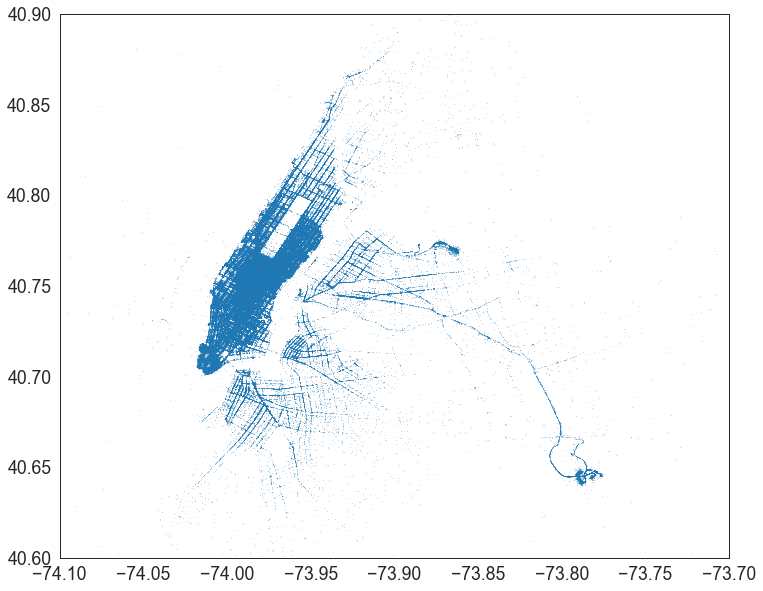

In [152]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(df['pickup_longitude'],df['pickup_latitude'], s=0.01, alpha=1)

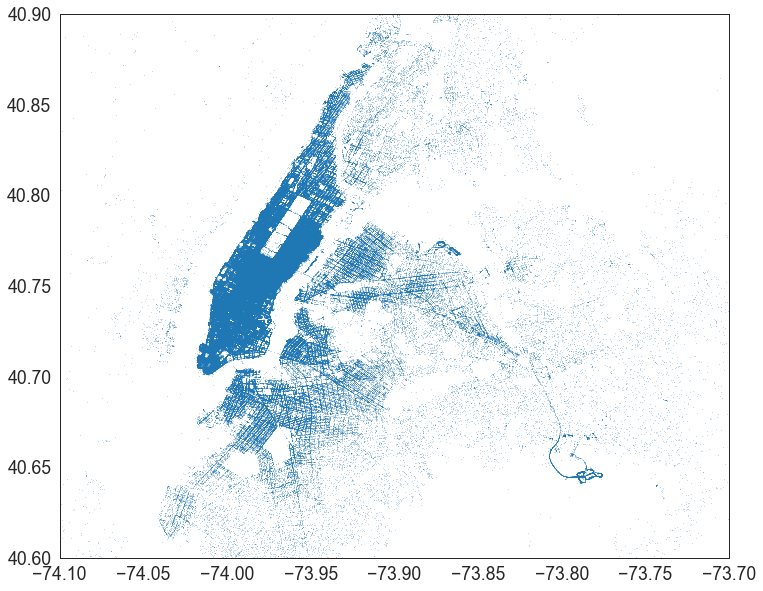

In [153]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(df['dropoff_longitude'],df['dropoff_latitude'], s=0.01, alpha=1)

In [154]:
def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

# Test data

In [155]:
tdf = pd.read_csv('data/test.csv')
tdf.pickup_datetime=pd.to_datetime(tdf.pickup_datetime)
#tdf.dropoff_datetime=pd.to_datetime(tdf.dropoff_datetime)
tdf['pu_hour'] = tdf.pickup_datetime.dt.hour
tdf['yday'] = tdf.pickup_datetime.dt.dayofyear
tdf['wday'] = tdf.pickup_datetime.dt.dayofweek
tdf['month'] = tdf.pickup_datetime.dt.month
tdf['distance'] = haversine(tdf.pickup_longitude, tdf.pickup_latitude,
                                           tdf.dropoff_longitude, tdf.dropoff_latitude)
fastest_test = pd.read_csv('data/fastest_routes_test.csv')
tdf = pd.merge(tdf,fastest_test,on='id',how='outer')
tdf = tdf.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
tdf = pd.merge(tdf,wdf,on='yday')
tdf = tdf.drop(['date','maximum temperature','minimum temperature'],axis=1)
tdf['jfk_pickup_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['lga_pickup_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['jfk_dropoff_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['lga_dropoff_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['jfk'] = ((tdf['jfk_pickup_dist'] < 2) | (tdf['jfk_dropoff_dist'] < 2))
tdf['lga'] = ((tdf['lga_pickup_dist'] < 2) | (tdf['lga_dropoff_dist'] < 2))
tdf = tdf.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
tdf['workday'] = ((tdf['pu_hour'] > 8) & (tdf['pu_hour'] < 18))

In [156]:
tdf['snowfall'] = tdf['snow fall'].replace(['T'],0.05)
tdf['precipitation'] = tdf['precipitation'].replace(['T'],0.05)
tdf['snowdepth'] = tdf['snow depth'].replace(['T'],0.05)

In [157]:
tdf.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,yday,wday,month,distance,total_distance,total_travel_time,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,jfk,lga,workday
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,182,3,6,1.705478,3795.9,424.6,76.0,0.0,0.0,0,0.0,0,False,False,False
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,182,3,6,1.713435,2904.5,200.0,76.0,0.0,0.0,0,0.0,0,False,False,False
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,182,3,6,0.811098,1499.5,193.2,76.0,0.0,0.0,0,0.0,0,False,False,False
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,182,3,6,3.272003,7023.9,494.8,76.0,0.0,0.0,0,0.0,0,False,False,False
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,182,3,6,0.596664,1108.2,103.2,76.0,0.0,0.0,0,0.0,0,False,False,False


In [158]:
df.to_csv('data/train_data.csv', index=False)
tdf.to_csv('data/test_data.csv', index=False)

In [159]:
df = pd.read_csv('data/train_data.csv')
tdf = pd.read_csv('data/test_data.csv')

/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [160]:
benchmark = fastest_test[['id','total_travel_time']]
benchmark = benchmark.rename(index=str, columns={"total_travel_time": "trip_duration"})
benchmark.head()

,id,trip_duration
0,id0771704,200.2
1,id3274209,141.5
2,id2756455,324.6
3,id3684027,84.2
4,id3101285,294.7


In [161]:
benchmark['trip_duration'].isnull().values.any()

False

In [162]:
benchmark.to_csv('benchmark.csv', index=False)

In [163]:
features = df[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]
target = df['trip_duration']

In [164]:
tfeatures = tdf[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]

# Training model

# 1) Linear Regression

In [223]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv, scoring=rmsle))
reg.fit(features, target)

Number predicted less than 0: (14,)
Number predicted less than 0: (9,)
Number predicted less than 0: (17,)
Number predicted less than 0: (12,)
[0.43999629 0.44022777 0.43897461 0.44073686]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [224]:
np.mean([0.43999617,  0.44022755 , 0.43897449,0.44073678])

0.4399837475

In [225]:
tfeatures.shape

(625134, 17)

In [226]:
pred = reg.predict(tfeatures)

In [228]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id', 'trip_duration']]

In [229]:
out['trip_duration'].isnull().values.any()

False

In [232]:
out.to_csv('pred_linear.csv', index=False)

# 2) K-nearest Neighbors Regression

In [233]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=10)
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(neigh, features, np.ravel(target), cv=cv, scoring=rmsle))
neigh.fit(features, target)

Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[0.42011203 0.4194096  0.41947696 0.41968832]


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [234]:
np.mean([0.42010954, 0.41940803, 0.41947931, 0.41968818])

0.419671265

In [235]:
pred = neigh.predict(tfeatures)

In [236]:
tdf['trip_duration'] = pred.astype(int)
out = tdf[['id', 'trip_duration']]
out.to_csv('pred_knn.csv', index=False)

# RandomForest

In [238]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(rf, features, np.ravel(target), cv=cv, scoring=rmsle))
rf.fit(features, target)

/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)


/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)


/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)


/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)
[0.35039425 0.35071238 0.35064761 0.35009692]


/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [239]:
np.mean([0.35085909, 0.35181223, 0.34976928, 0.35057147])

0.3507530175

In [240]:
pred = rf.predict(tfeatures)

In [241]:
tdf['trip_duration'] = pred.astype(int)
out = tdf[['id', 'trip_duration']]
out.to_csv('pred_rf.csv', index=False)

# XGBoost

In [167]:
reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv,scoring=rmsle))
reg.fit(features,target)

[13:05:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[13:11:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[13:18:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[13:25:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[0.34320702 0.3440338  0.34316219 0.3432831 ]


/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [169]:
pred = reg.predict(tfeatures)

In [170]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('pred_xgboost.csv',index=False)

# XGBoost was the best result, and needs parameter tuning

# XGBoost with GridCV(max_depth, min_child_weight)

In [171]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.08, 'n_estimators': 100, 'seed':0, 'subsample': 0.75, 'colsample_bytree': 1}
optimized_GBM = GridSearchCV(xgboost.XGBRegressor(**ind_params), 
                            cv_params,scoring = rmsle, cv =4) 
optimized_GBM.fit(features, np.ravel(target))

[15:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[15:10:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[15:12:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (1,)
[15:15:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[15:17:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[15:20:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[15:22:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.08,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=None,
                                    subsample=0.75, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
             pre_dispatch='2*n_jobs', re

In [175]:
pred = optimized_GBM.predict(tfeatures)

In [176]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('gridCV1.csv',index=False)

# XGBoost with GridCV(learning_rate, subsample)

In [178]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 100, 'seed':0, 'colsample_bytree': 1, 
             'max_depth': 7, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgboost.XGBRegressor(**ind_params), 
                             cv_params,scoring = rmsle, cv =4) 
optimized_GBM.fit(features, np.ravel(target))

[23:17:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (2,)
[23:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[23:27:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[23:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (1,)
[23:38:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (2,)
[23:43:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[23:49:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01],
                         'subsample': [0.7, 0.8, 0.9]},
             p

In [183]:
optimized_GBM.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

# best estimator, params mean the worst result here bcs of scoring=rmsle

In [186]:
optimized_GBM.best_params_

{'learning_rate': 0.01, 'subsample': 0.7}

In [187]:
optimized_GBM.cv_results_

{'mean_fit_time': array([314.13185257, 309.10534871, 306.68673545, 308.58813059,
        299.90220791, 291.60453779]),
 'std_fit_time': array([ 1.78341561,  0.76946799,  0.7263097 , 12.8881599 , 10.32258357,
         4.25959351]),
 'mean_score_time': array([5.80159247, 5.74556756, 5.79493821, 6.06476754, 5.6660521 ,
        5.49545836]),
 'std_score_time': array([0.07850196, 0.03242839, 0.08101585, 0.45100675, 0.19034578,
        0.24435859]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.7, 0.8, 0.9, 0.7, 0.8, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1, 'subsample': 0.7},
  {'learning_rate': 0.1, 'subsample': 0.8},
  {'learning_rate': 0.1, 'subsample': 0.9},
  {'learning_rate': 0.01, 'subsam

In [190]:
pred = optimized_GBM.predict(tfeatures)

In [191]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('gridCV2.csv',index=False)

# find the best parameters by cv results 

In [192]:
params = {'n_estimators': 100, 'seed':0, 'colsample_bytree': 1, 
             'max_depth': 7, 'min_child_weight': 1,'learning_rate': 0.1, 'subsample': 0.8}

In [193]:
reg = xgboost.XGBRegressor(n_estimators=100, seed=0,learning_rate=0.1, subsample=0.8,
                           colsample_bytree=1, max_depth=7,min_child_weight= 1)

cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv,scoring=rmsle))
reg.fit(features,target)

[02:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (1,)
[02:38:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[02:45:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (1,)
[02:52:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[0.34033521 0.34164258 0.33955081 0.34045656]
[02:59:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.8, verbosity=1)

In [194]:
pred = reg.predict(tfeatures)

In [195]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('pred_xgboost2.csv',index=False)